In [1]:
# Primary Libraries
import ast
import re
from fuzzywuzzy import process
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import dataframe_image as dfi

# http://shakedzy.xyz/dython/modules/nominal/
from dython.nominal import associations
import scipy.stats as ss

# Libraries for ML Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer
from sklearn.decomposition import PCA

# Libraries for Binary Classification
import category_encoders as ce
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score, LearningCurveDisplay
from sklearn.metrics import classification_report, make_scorer, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier

# Libraries for Recommender System
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Libraries for Customer Segmentation
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, silhouette_visualizer
from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator

import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 300)
sns.set_theme(style="whitegrid", palette="pastel")

C:\Users\idben\anaconda3\envs\oldBase\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**Project Structure:**
- 05.01: Introduction
- 05.02: Preprocessing
- 05.03: Customer Segmentation Without Relying on Plan Code (CS General)
- 05.04: Customer Segmentation Based on Plan Code (Plan Code-based CS)
- 05.05: Customer Segmentation Based on 'Premium Amount' that Has Been Quantile-binned (Premium Amount-based CS)
- 05.06: Overall Trend Findings - Customer Segmentation
- 06: Further Insights


## 05: Customer Segmentation
#### 05.01: Introduction
The goal of customer segmentation is to categorize customers and create profiles based on their shared characteristics. 

Customer segmentation involves grouping a company's customers into various segments with similar traits. This approach enables businesses to enhance their marketing and product strategies for different customer groups. Segmentation also assists companies in identifying opportunities to refine their products, enhance customer relationships, and experiment with different pricing strategies. By concentrating on their most profitable customers and implementing upselling and cross-selling techniques, segmentation becomes a potent tool for optimizing marketing efforts and fostering business growth.

There are 3 customer segmentations result in this project:
1. Customer segmentation without relying on 'Plan Code' (CS General), using **K-Prototypes algorithm.**
2. Customer segmentation that is based on 'Plan Code' (Plan Code-based CS), using **groupby() method**
3. Customer segmentation based on 'Premium Amount' that has been quantile-binned (Premium Amount-based CS), using **groupby() method**

**Dataset Description:**
1. 'City Code': The code of the City
2. 'Age' = Customers' age
3. 'Married_Insured': Column combined from 'Married' and 'Insurance Type' columns
4. 'Plan Code': Unique product code per insurance product
5. 'Policy Duration': Duration of active policy
6. 'Policy Type': Type of insurance policy (e.g there could be someone who buys an insurance policy only or an insurance policy plus a health rider)
7. 'Policy Category': Grouping category for the policy type (e.g. polis category A adalah polis tipe Health and Jiwa).
8. 'Premium Amount': The total amount of premiums we receive from insurance customers.
9. 'customer_lifetime' = Number of years as our customer

<hr>

**Notes:**

1. The first customer segmentation is not reliant on the 'Plan Code' as the goal is to identify general customer trends.
2. Conversely, the second customer segmentation is centered on the 'Plan Code' (insurance products) to gain insights into the profiles associated with these products.
3. Furthermore, the third customer segmentation is based on 'Premium Amount' that has been binned to analyze customer trends related to differences in 'Premium Amount' variances.

Moreover, companies often develop products customized for each of their customer segments, and thus, we are exploring factual data pertaining to specific predefined segments within a company. In this project, 'CS' refers to 'customer segmentation'.

#### 05.02: Preprocessing

In [2]:
# Establishing constants
RANDOM_STATE = 2023

In [3]:
# Importing the dataset
raw_df = pd.read_csv('data-cleaned.csv')
df = raw_df.copy()
df.drop(columns=['Unnamed: 0'], inplace=True)

# Categorizing columns based on their dtypes
list_str = ['Customer ID', 'City Code', 'Accomodation Ownership', 'Married_Insured', 'Plan Code', 'Policy Duration', 'Policy Type', 'Policy Category', 'Response', 'isLoyal', 'prodScore']
list_float = ['Premium Amount', 'premium_lifetime', 'premium_LTYes', 'premium_LTNo']
list_int = [i for i in df.columns if (i not in list_str) and (i not in list_float)]

# Changing data types
for i in df.columns:
    if i in list_str:
        df[i] = df[i].astype('str')
    elif i in list_float:
        df[i] = df[i].astype('float')
    else:
        df[i] = df[i].astype('int32')
df['prodScore'] = df['prodScore'].apply(ast.literal_eval)
df.head()

,Customer ID,City Code,Accomodation Ownership,Age,Married_Insured,Plan Code,Policy Duration,Policy Type,Policy Category,Premium Amount,Response,customer_lifetime,isLoyal,premium_lifetime,purchase_frequency,prodScore,premium_LTYes,premium_LTNo,numProdTried,impression
0,81716,C2,Rented,75,2,X2,4.0,3,21,44689.0,0,0,0,92908.0,2,"{'X2': -1.5, 'X1': -1.5}",0.0,92908.0,2,-3
1,80492,C13,Owned,75,2,X1,6.0,3,18,15141.0,1,0,0,15141.0,1,{'X1': 1.5},15141.0,0.0,1,1
2,75895,C14,Owned,75,2,X2,1.0,3,8,33206.0,1,52,1,76905.0,2,{'X2': 0.5},33206.0,43699.0,1,0
3,85258,C4,Owned,75,2,X1,8.0,2,20,31657.0,0,50,1,98867.0,3,"{'X1': -1.5, 'X2': 0.5}",30585.0,68282.0,2,-1
4,80292,C3,Owned,75,2,X1,2.0,2,16,37167.0,0,0,0,37167.0,1,{'X1': -1.5},0.0,37167.0,1,-1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15188 entries, 0 to 15187
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             15188 non-null  object 
 1   City Code               15188 non-null  object 
 2   Accomodation Ownership  15188 non-null  object 
 3   Age                     15188 non-null  int32  
 4   Married_Insured         15188 non-null  object 
 5   Plan Code               15188 non-null  object 
 6   Policy Duration         15188 non-null  object 
 7   Policy Type             15188 non-null  object 
 8   Policy Category         15188 non-null  object 
 9   Premium Amount          15188 non-null  float64
 10  Response                15188 non-null  object 
 11  customer_lifetime       15188 non-null  int32  
 12  isLoyal                 15188 non-null  object 
 13  premium_lifetime        15188 non-null  float64
 14  purchase_frequency      15188 non-null

In [5]:
df_cluster = df[df['Response']=='1']

In [6]:
df_cluster.head()

,Customer ID,City Code,Accomodation Ownership,Age,Married_Insured,Plan Code,Policy Duration,Policy Type,Policy Category,Premium Amount,Response,customer_lifetime,isLoyal,premium_lifetime,purchase_frequency,prodScore,premium_LTYes,premium_LTNo,numProdTried,impression
1,80492,C13,Owned,75,2,X1,6.0,3,18,15141.0,1,0,0,15141.0,1,{'X1': 1.5},15141.0,0.0,1,1
2,75895,C14,Owned,75,2,X2,1.0,3,8,33206.0,1,52,1,76905.0,2,{'X2': 0.5},33206.0,43699.0,1,0
9,81826,C7,Owned,75,2,X1,14+,3,9,35950.0,1,0,0,35950.0,1,{'X1': 1.5},35950.0,0.0,1,1
10,75746,C4,Owned,75,2,X1,4.0,3,14,16319.0,1,0,0,50529.0,2,"{'X1': 1.5, 'X5': 1.5}",50529.0,0.0,2,3
15,87818,C20,Owned,75,2,X3,7.0,3,22,24286.0,1,5,1,98135.0,3,"{'X3': 1.5, 'X1': 0.5}",56167.0,41968.0,2,2


In [7]:
# Creating a KPrototypes clustering function
def kprotoClustering(df, features):
    ## The 'features' variable below is intended for debugging purposes
    # features = ['City Code', 'Age', 'Plan Code', 'Policy Duration', 'Policy Type', 'Policy Category', 'Premium Amount', 'customer_lifetime', 'premium_lifetime', 'impression']
    X = df[features].copy()

    # Categorizing the features based on their data types
    list_categorical = X.select_dtypes(include='object').columns.values.tolist()  # K-Prototypes does not require any categorical encoding prior fitting the model
    list_numerical = [i for i in X.columns if i not in list_categorical]
    
    # Categorizing the features based on their preprocessing requirements
    list_stdScaler = ['Premium Amount', 'impression']
    list_stdScaler = [i for i in list_stdScaler if i in features]  # If 'Premium Amount' and 'impression' are not present among the features, the list_stdScaler will be empty.
    list_robScaler = [i for i in list_numerical if i not in list_stdScaler]

    # Creating a column transformer for the dataset
    trans = ColumnTransformer([
        ('stdScaler', StandardScaler(), list_stdScaler),
        ('robScaler', RobustScaler(), list_robScaler)
    ])
    
    # Creating a dataframe transform 
    Xnum_tr = trans.fit_transform(X[list_numerical])
    df_Xnum_tr = pd.DataFrame(Xnum_tr, columns=trans.get_feature_names_out())
    df_Xcat = X[list_categorical]

    df_combined = pd.concat([df_Xnum_tr.reset_index(drop=True), df_Xcat.reset_index(drop=True)], axis=1)  # Combining the numerical and categorical features
    id_cat = [df_combined.columns.get_loc(i) for i in list_categorical]  # Grabbing the categorical columns id
    df_matrix = df_combined.to_numpy()  # Converting the df_combined into a matrix array, as KPrototypes only accepts data in array form

    cost = []  # Similar to the elbow method in K-Means, K-Prototypes aims to find the highest reduction in the cost function per K cluster iteration
    for cluster in tqdm(range(1, 10)):  # Setting up 1-10 clusters
        try:
            kprototype = KPrototypes(n_jobs = -1, n_clusters=cluster, init='Huang', random_state=RANDOM_STATE)
            kprototype.fit_predict(df_matrix, categorical=id_cat)  # In the K-Prototypes algorithm, the index locations of categorical columns should be passed using the 'categorical' parameter
            cost.append(kprototype.cost_)  # Appending all the costs from K cluster iterations
            print(f'Clustering with K: {cluster}')
        except:
            break

    plt.plot(range(1,10), cost)  # Line-plotting the cost funcction
    plt.xlabel('K Clusters')
    plt.ylabel('Cost KPrototypes')
    plt.title('Elbow Method KPrototypes Using Cost Function')
    plt.show()

    
    # Creating Knee Locator to find the best K for KPrototypes clustering.
    # https://pypi.org/project/kneed/#documentation
    # https://kneed.readthedocs.io/en/stable/
    cost_kneeLocator = KneeLocator(x=range(1,10), y=cost, curve='convex', direction='decreasing', online=True)
    print(f"The Best K for the KPrototypes Clustering: {cost_kneeLocator.elbow} clusters")

    kprototype = KPrototypes(n_jobs=14, n_clusters=cost_kneeLocator.elbow, init='Huang', random_state=RANDOM_STATE)
    label = kprototype.fit_predict(df_matrix, categorical=id_cat)

    df_result = X.copy()
    df_result['label'] = label

    return df_result, list_numerical, list_categorical

In [8]:
# Creating a profile based on the median confidence interval, as most of the data are not normally distributed. 
# The mean confidence interval is highly sensitive to outliers; thus, we are going to use the median confidence interval instead.
# This median confidence interval is based on the Z-statistic. If the sample size is above 30, we can use the Z-statistic.
# https://www.statology.org/confidence-interval-for-median/
def median_confidenceInterval(array, confidence):
    mean = np.mean(array)
    median = np.median(array)
    n = len(array)  # Len of the array
    q = 0.5  # The quantile of interest, median = 0.5
    z = ss.norm.ppf((1+confidence)/2)
    return median, n, q, z, mean

# Creating a function that returns the lower bound of median confidence interval
def median_confidenceInterval_lower(array, confidence=.95):
    median, n, q, z, mean = median_confidenceInterval(array, confidence)
    j = math.ceil((n*q)-z*math.sqrt((n*q*(1-q))))  # lower bound interval index
    result_lower = array[j]  # median lower bound
    return result_lower

# Creating a function that returns the lower bound of median confidence interval
def median_confidenceInterval_lower2(array, confidence=.95):
    median, n, q, z, mean = median_confidenceInterval(array, confidence)
    try:
        j = math.ceil((n*q)-z*math.sqrt((n*q*(1-q))))  # lower bound interval index
        result_lower = array[j]  # median lower bound
    except:
        result_lower = np.nan
    return result_lower

# Creating a function that returns the upper bound of median confidence interval
def median_confidenceInterval_upper(array, confidence=.95):
    median, n, q, z, mean = median_confidenceInterval(array, confidence)
    k = math.ceil((n*q)+z*math.sqrt((n*q*(1-q))))  # Upper bound interval index
    result_upper = array[k]  # median upper bound
    return result_upper

# Creating a function that returns the upper bound of median confidence interval
def median_confidenceInterval_upper2(array, confidence=.95):
    median, n, q, z, mean = median_confidenceInterval(array, confidence)
    try:
        k = math.ceil((n*q)+z*math.sqrt((n*q*(1-q))))  # Upper bound interval index
        result_upper = array[k]  # median upper bound
    except:
        result_upper = np.nan
    return result_upper

# Creating function that removes duplicates in the intervals (e.g. interval '7 - 7' becomes '7')
def RemoveIntervalDuplicates(df):
    df_tidied = pd.DataFrame()
    try: 
        for i in df.columns:
            df_tidied[i] = df[i].str.split(' - ').apply(lambda x: x[0] if x[0] == x[1] else ' - '.join(x))
    except:
        print('Try generating the dataframe again if an error arises.')
    return df_tidied

In [9]:
# Create a function that manually groups the Data Frame and applies the median_confidenceInterval functions (both lower bound and upper bound functions),
# Since applying these functions to grouped DataFrame using pandas 'groupby' function yields to undesirable results.
def profile_generator(df, list_numerical, list_categorical):
    df_medianLower = pd.DataFrame()
    df_medianUpper = pd.DataFrame()

    for label in np.sort(df['label'].unique()):
        for column in list_numerical:
            arr_sorted = np.sort(df[df['label']==label][column].to_numpy())

            median_lowerbound = median_confidenceInterval_lower(arr_sorted)
            df_medianLower.loc[label, column] = median_lowerbound

            median_upperbound = median_confidenceInterval_upper(arr_sorted)
            df_medianUpper.loc[label, column] = median_upperbound

    df_medianLower = df_medianLower.astype('int64')
    df_medianUpper = df_medianUpper.astype('int64')

    # Creating median numerical DFs & categorical DF
    df_numerGB_MedianCI = df_medianLower.astype('str') + ' - ' + df_medianUpper.astype('str')  # Creating profiling based on the 'median' confidence interval of the data.
    df_numerGB_MedianCI = RemoveIntervalDuplicates(df_numerGB_MedianCI)
    df_categoGB_Mode = df[list_categorical+['label']].groupby('label').agg(pd.Series.mode)
    
    # Creating Population & Percent Population DFs
    groupPop = df.groupby('label').count().iloc[:,0].values
    df_pop = pd.DataFrame(groupPop, columns=['population'])  # Population per cluster
    df_percPop = df_pop.apply(lambda x: round(x/groupPop.sum()*100,2)).copy()  # Percent population per cluster
    df_percPop.columns = ['percPopulation']
    
    # Creating mean Premium Amount DF
    df_meanPA = pd.DataFrame(df.groupby('label').mean()['Premium Amount'].apply(lambda x: round(x, 2)).values, columns=['meanPremiumAmount'])
    
    # Combining all DFs into 1
    df_result = pd.concat([df_numerGB_MedianCI.reset_index(drop=True), df_categoGB_Mode.reset_index(drop=True), 
                           df_pop.reset_index(drop=True), df_percPop.reset_index(drop=True), 
                           df_meanPA.reset_index(drop=True)], axis=1)
    
    # Creating 'market_size' column
    df_result['market_size'] = round(df_result['meanPremiumAmount']*df_result['population'],2)
    df_result['market_size'] = df_result['market_size'].apply(lambda x: f"{x:,}")
    
    return df_result

#### 05.03: Customer Segmentation Without Relying on Plan Code (CS General)

 11%|█         | 1/9 [00:02<00:19,  2.39s/it]

Clustering with K: 1


 22%|██▏       | 2/9 [00:05<00:20,  2.87s/it]

Clustering with K: 2


 33%|███▎      | 3/9 [00:15<00:37,  6.26s/it]

Clustering with K: 3


 44%|████▍     | 4/9 [00:24<00:36,  7.30s/it]

Clustering with K: 4


 56%|█████▌    | 5/9 [00:35<00:34,  8.61s/it]

Clustering with K: 5


 67%|██████▋   | 6/9 [00:52<00:34, 11.41s/it]

Clustering with K: 6


 78%|███████▊  | 7/9 [01:01<00:20, 10.46s/it]

Clustering with K: 7


 89%|████████▉ | 8/9 [01:13<00:10, 10.96s/it]

Clustering with K: 8


100%|██████████| 9/9 [01:28<00:00,  9.84s/it]

Clustering with K: 9


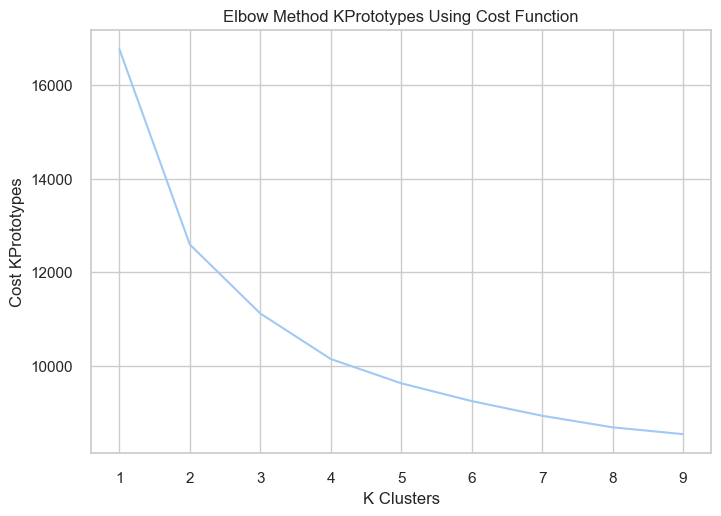

The Best K for the KPrototypes Clustering: 3 clusters


In [10]:
features = ['City Code', 'Age', 'Married_Insured', 'Plan Code', 'Policy Duration', 'Policy Type', 'Policy Category', 'Premium Amount', 'customer_lifetime']
df_c, listnum, listcat = kprotoClustering(df_cluster, features)

In [11]:
# Creating customer segmentation without relying on the 'Plan Code'
profile_woPlanCode = profile_generator(df_c, listnum, listcat)
profile_woPlanCode.sort_values('market_size', ascending=False, inplace=True)
profile_woPlanCode

,Age,Premium Amount,customer_lifetime,City Code,Married_Insured,Plan Code,Policy Duration,Policy Type,Policy Category,population,percPopulation,meanPremiumAmount,market_size
2,43 - 45,39819 - 40657,0,C2,2,X1,1.0,3,22,1996,36.03,39975.23,"79,790,559.08"
0,48 - 50,18237 - 18919,0,C1,2,X1,1.0,3,22,2313,41.75,18924.89,"43,773,270.57"
1,67 - 68,33337 - 34715,35 - 37,C1,2,X1,1.0,3,22,1231,22.22,34235.40,"42,143,777.4"


In [12]:
# dfi.export(profile_woPlanCode, "pic/profile_woPlanCode.png")

**Findings:**

Without relying on the 'Plan Code' or predefined segments as the basis for customer segmentation, it becomes evident that **Profile 2 holds the largest market size**, even though its population percentage (*approximately 36%*) is smaller than that of the largest population holder, which is customers in Profile 0 (*with a population percentage of around 42%*).

All customer segments exhibit the **same characteristics in the** 'Married_Insured,' 'Plan Code,' 'Policy Duration,' 'Policy Type,' and 'Policy Category' features. This implies that the majority of customers are not married, they potentially purchase insurance products for themselves only, predominantly opt for the X1 insurance product, have short active policy durations (*1 year only*), and their 'Policy Type' and 'Policy Category' are 3 and 22, respectively.

The **most notable differences among these segments**, aside from their population variances, are observed in their 'Age', 'Premium Amount', 'Customer Lifetime', and 'City Code' features.

*Let's see __if the customers exhibit the same characteristics when customer segmentation is based on 'Plan Code'__, which represents the insurance products*

<hr>

*Note: The index represents cluster profiles, while the columns represent features.*

*Notes for 'Married_Insured' column:*
1. Variable 1 = ('Married': 'No') & ('Insurance Type': 'Joint'), assumption: Single customers who purchased insurance for themselves and another family member or friend.
2. Variable 2 = ('Married': 'No') & ('Insurance Type': 'Personal'), assumption: Single customers who purchased insurance for themselves.
3. Variable 3 = ('Married': 'Yes') & ('Insurance Type': 'Joint'), assumption: Married customers who purchased insurance for themselves and their partners.*

#### 05.04: Customer Segmentation Based on Plan Code (Plan Code-based CS)

In [13]:
# Creating customer segmentation from insurance products, based on the 'Plan Code' column
# The numerical features are based on median confidence interval, while the categoricals are based on mode
listnum_PlanCode = ['Age', 'Premium Amount', 'customer_lifetime']
listcat_PlanCode = ['City Code', 'Married_Insured', 'Policy Duration', 'Policy Type', 'Policy Category', 'Plan Code']
df_forPlanCode = df_cluster[listnum_PlanCode+listcat_PlanCode].copy()
df_forPlanCode['label'] = df_forPlanCode['Plan Code']

profile_wiPlanCode = profile_generator(df_forPlanCode, listnum_PlanCode, listcat_PlanCode)
profile_wiPlanCode.set_index('Plan Code', inplace=True)
profile_wiPlanCode

,Age,Premium Amount,customer_lifetime,City Code,Married_Insured,Policy Duration,Policy Type,Policy Category,population,percPopulation,meanPremiumAmount,market_size
Plan Code,,,,,,,,,,,,
X1,52 - 54,29222 - 30943,3 - 6,C1,2,1.0,3,22,2378,42.92,30002.41,"71,345,730.98"
X2,50 - 53,28979 - 31248,2 - 6,C1,2,1.0,3,22,1258,22.71,30056.43,"37,810,988.94"
X3,50 - 55,28504 - 30974,0 - 5,C1,2,1.0,3,22,755,13.63,29991.51,"22,643,590.05"
X4,49 - 53,27778 - 31113,2 - 7,C1,2,1.0,3,22,708,12.78,29617.12,"20,968,920.96"
X5,48 - 56,25013 - 30988,0 - 6,C2,2,1.0,3,22,218,3.94,28638.45,"6,243,182.1"
X6,55 - 60,28433 - 35390,0 - 10,C2,2,1.0,3,15,155,2.80,30357.46,"4,705,406.3"
X7,55 - 65,23731 - 38462,0 - 22,C1,2,1.0,3,22,42,0.76,30691.60,"1,289,047.2"
X8,40 - 63,18307 - 43237,0 - 27,C1,2,1.0,3,15,14,0.25,24671.86,"345,406.04"
X9,32 - 70,20738 - 43727,0 - 33,C9,2,1.0,3,12,12,0.22,29611.75,"355,341.0"


In [14]:
# dfi.export(profile_wiPlanCode, "pic/profile_wiPlanCode.png")

**Findings:**

It can be see that the majority of customers buy **X1** product, around 43%, this percentage is almost equal to the total percentage of **X2, X3, X4** customers, which is at around 49%. In contrast **x5 and x6** products are considered a niche products because these customers are at approximately 4% and 3%, respectively. Furthermore, **X8 and x9** products are for the super niche segments as the total customer percentage of these segments are around 0.5%.

Since the difference in the average premium amount for X1, X2, X3, and X4 is negligible, the company **should prioritize focusing on X1**, followed by X2, X3, and X4 products, as they have the largest market share among customers based on insurance products. X1 holds the biggest market size within the overall segments.

Marketers can use this profile as a guide for their **marketing strategies**, encompassing the 4Ps (price, place, product, promotion), to effectively target and engage with their customers while selecting the most profitable segments.

Furthermore, the **same characteristics** that were observed in the customer segmentation without relying on the 'Plan Code' (CS General) appear in this customer segmentation (Plan Code-based CS). In both cases, all segments exhibit the same traits in the 'Married_Insured,' 'Policy Duration,' and 'Policy Type' features. However, the characteristic found in CS General, where all segments exhibit the same traits in the 'Policy Category' column, **is not present** in this Plan Code-based CS.

The **most notable differences among these segments**, apart from their population variances, are observed in their 'Age,' 'Premium Amount,' 'Customer Lifetime,' and 'City Code' features, just as seen in CS General.

*Let's __investigate whether customers exhibit the same characteristics when customer segmentation is based on 'Premium Amount' that has been quantile-binned.__*

<hr>

*Note: The index represents cluster profiles, while the columns represent features.*

*Notes for 'Married_Insured' column:*
1. Variable 1 = ('Married': 'No') & ('Insurance Type': 'Joint'), assumption: Single customers who purchased insurance for themselves and another family member or friend.
2. Variable 2 = ('Married': 'No') & ('Insurance Type': 'Personal'), assumption: Single customers who purchased insurance for themselves.
3. Variable 3 = ('Married': 'Yes') & ('Insurance Type': 'Joint'), assumption: Married customers who purchased insurance for themselves and their partners.*

#### 05.05: Customer Segmentation Based on 'Premium Amount' that Has Been Quantile-binned (Premium Amount-based CS)

In [15]:
kbins = KBinsDiscretizer(encode='ordinal', strategy='quantile')
listnum_PremiumAmount = ['Age', 'customer_lifetime', 'Premium Amount']
listcat_PremiumAmount = ['City Code', 'Married_Insured', 'Plan Code', 'Policy Duration', 'Policy Type', 'Policy Category']

df_forPremiumAmount = df_cluster[listnum_PremiumAmount+listcat_PremiumAmount].copy()
df_forPremiumAmount['PA_binned'] = kbins.fit_transform(df_forPremiumAmount[['Premium Amount']])
df_forPremiumAmount['label'] = df_forPremiumAmount['PA_binned']

profile_PremiumAmount = profile_generator(df_forPremiumAmount, listnum_PremiumAmount, listcat_PremiumAmount)
# profile_PremiumAmount.set_index('PA_binned', inplace=True)
profile_PremiumAmount

,Age,customer_lifetime,Premium Amount,City Code,Married_Insured,Plan Code,Policy Duration,Policy Type,Policy Category,population,percPopulation,meanPremiumAmount,market_size
0,50 - 53,2 - 6,13718 - 14209,C1,2,X1,1.0,3,22,1108,20.0,13948.87,"15,455,347.96"
1,52 - 54,1 - 6,21756 - 22288,C1,2,X1,1.0,3,22,1108,20.0,21875.01,"24,237,511.08"
2,52 - 55,3 - 7,29665 - 30101,C1,2,X1,1.0,3,22,1108,20.0,29885.14,"33,112,735.12"
3,51 - 54,1 - 6,37729 - 38152,C1,2,X1,1.0,3,22,1108,20.0,37977.75,"42,079,347.0"
4,51 - 55,1 - 5,45530 - 46221,C1,2,X1,1.0,3,22,1108,20.0,45868.84,"50,822,674.72"


In [16]:
# dfi.export(profile_PremiumAmount, "pic/profile_PremiumAmount.png")

In [17]:
# 'Premium Amount' is divided into bins based on its quantiles since it is not normally distributed
print(f"Below are the bin edges for each quantile: {kbins.bin_edges_.tolist()[0].tolist()}")

Below are the bin edges for each quantile: [10014.0, 17929.2, 25720.8, 33993.8, 41769.0, 49989.0]


Findings:

Since the customer segmentation based on 'Premium Amount' that has been quantile-binned results in the same frequency/population for each of the segments, the only factor influencing the market size in each segment is the average Premium Amount found in 'meanPremiumAmount'. **The largest market size** in this customer segmentation is in segment/cluster/profile 4, while **the smallest market size** is in segment 0.

Furthermore, the table above also reveals that the same characteristics found in CS General and Plan Code-based CS are also present in Premium Amount-based CS. In all these types of customer segmentation, all segments exhibit the same traits in the 'Married Insured,' 'Policy Type,' and 'Policy Category' features. Additionally, all segments display the same traits in the 'Married_Insured' feature, as seen in CS General.

The **most notable differences** among these segments, aside from their 'meanPremiumAmount' variances, are observed in their 'Age' and 'customer_lifetime' features.

<hr>

*Note: The index represents cluster profiles, while the columns represent features.*

*Notes for 'Married_Insured' column:*
1. Variable 1 = ('Married': 'No') & ('Insurance Type': 'Joint'), assumption: Single customers who purchased insurance for themselves and another family member or friend.
2. Variable 2 = ('Married': 'No') & ('Insurance Type': 'Personal'), assumption: Single customers who purchased insurance for themselves.
3. Variable 3 = ('Married': 'Yes') & ('Insurance Type': 'Joint'), assumption: Married customers who purchased insurance for themselves and their partners.*

#### 05.06: Overall Trend Findings - Customer Segmentation

1. In most types of customer segmentations, all segments exhibit the same traits in the 'Married_Insured,' 'Policy Duration', 'Policy Type,' 'Policy Category', and/or 'Plan Code' features. These concludes that the majority of customers, have the same tendency towards these features regardless the types of customer segmentation. 
2. Among those types of customer segmentation, the notable difference are usually found in 'Age', 'customer_lifetime', 'Premium Amount' features.
3. Marketers can use these customer segmentations as their guidance in targeting the most profitable segments and creating the most suitable marketing strategies, such as 4Ps (Product, Price, Place, Promotion)

<hr>

Note on 4Ps:
- Product: involves understanding, defining, and strategically positioning a product to meet consumer needs, considering its life cycle, cost, placement, and promotion, often emphasizing innovation to gain a competitive edge
- Price: entails determining the value consumers are willing to pay for a product, considering factors such as real and perceived value, supply costs, competition, and the potential impact of discounts, which can either attract more customers or imply reduced desirability
- Place: involves deciding where and how a product should be available, whether in physical stores or online, as well as optimizing its display and advertising to capture the attention of the target audience
- Promotion: involves conveying the product's necessity and value to consumers through advertising, public relations, and media strategies, with an emphasis on online presence

#### 06: Further Insights

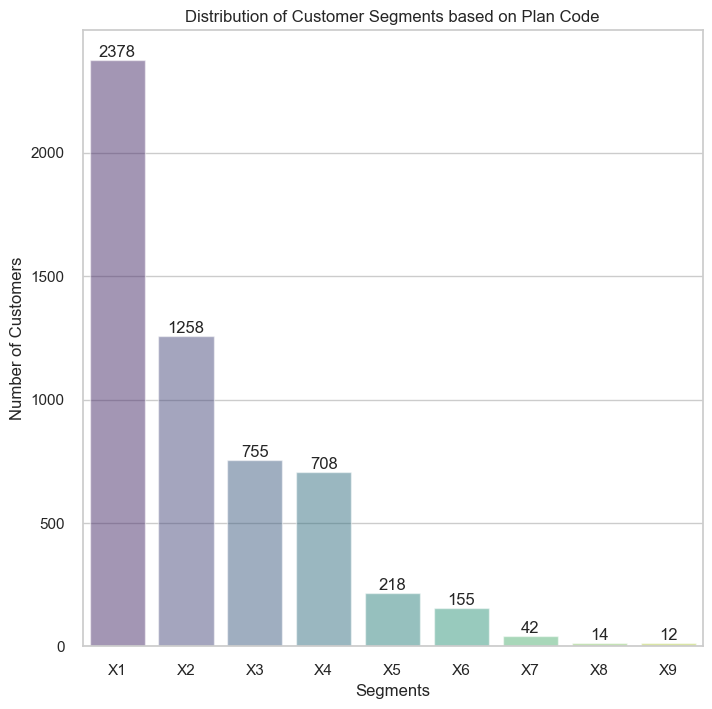

In [18]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x=df_forPlanCode['label'].value_counts().index, y=df_forPlanCode['label'].value_counts().values, palette="viridis", alpha=.5)
ax.bar_label(ax.containers[0])  # Adding label
plt.title('Distribution of Customer Segments based on Plan Code')
plt.xlabel('Segments')
plt.ylabel('Number of Customers')
plt.show()

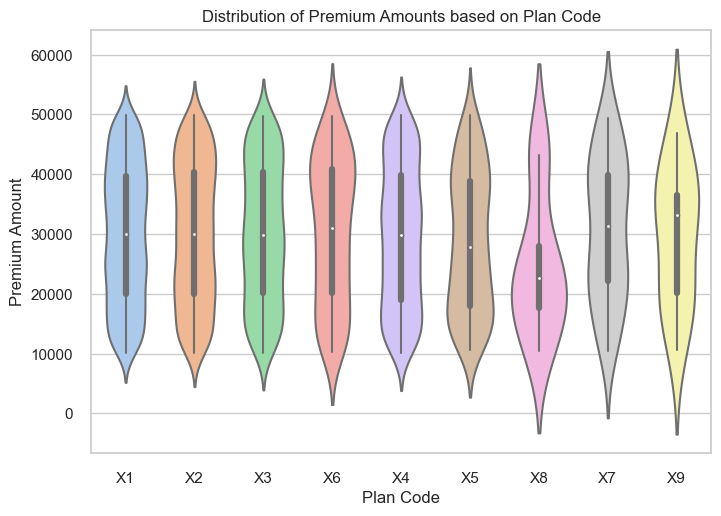

In [19]:
sns.violinplot(x=df_forPlanCode['label'], y=df_forPlanCode['Premium Amount'], alpha=.6)
plt.title('Distribution of Premium Amounts based on Plan Code')
plt.xlabel('Plan Code')
plt.ylabel('Premium Amount')
plt.show()

This violin plot clearly indicates that nearly all segments have a similar distribution and median in the 'Premium Amount' feature, with the exception of the 'X8' segment

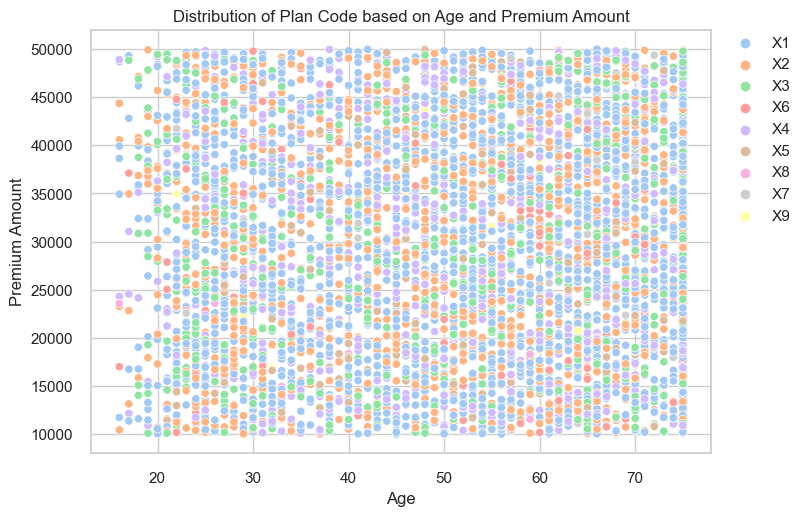

In [20]:
sns.scatterplot(x=df_forPlanCode['Age'], y=df_forPlanCode['Premium Amount'], hue=df_forPlanCode['label'])
plt.title('Distribution of Plan Code based on Age and Premium Amount')
plt.ylabel('Premium Amount')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

The scatter plot above illustrates that the distribution of 'Plan Code' based on 'Age' and 'Premium Amount' is fairly consistent. Additionally, it reveals that X1, X2, X3, and X4 products dominate across various age groups and premium amounts.

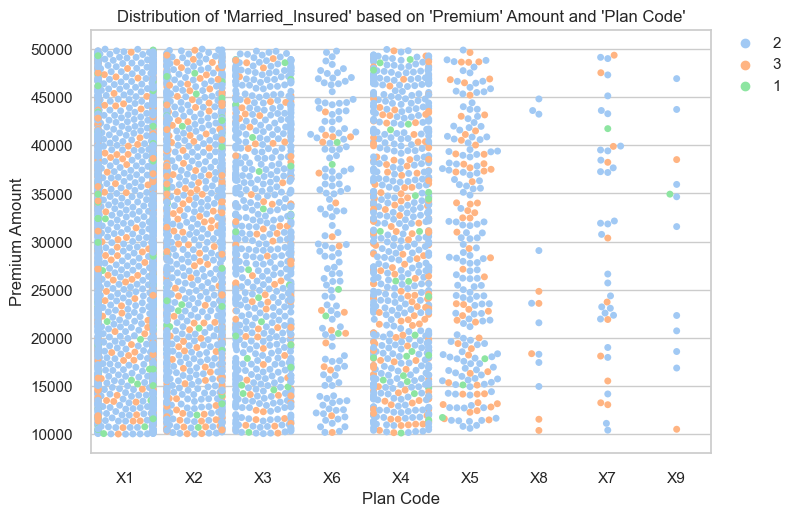

In [21]:
sns.swarmplot(x=df_forPlanCode['label'], y=df_forPlanCode['Premium Amount'], hue=df_forPlanCode['Married_Insured'])
plt.title("Distribution of 'Married_Insured' based on 'Premium' Amount and 'Plan Code'")
plt.ylabel('Premium Amount')
plt.xlabel('Plan Code')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

By creating a swarm plot that displays 'Plan Code' against 'Premium Amount' and using the 'Married_Insured' column as the hue, underlying trends that were less visible before become evident. 

Category 2 customers can be seen across the segments, confirming what the customer segmentation table has shown previously (Plan Code-based CS). However, it is also noticeable that there are several Category 3 and Category 1 customers in almost all of these segments. **Category 3 customers** are present in all segments, but they are more prominent in X1, X2, X3, X4, and X5 products. In contrast, **Category 1 customers** are more prominent in X1, X2, X3, and X4 products.

<hr> 

*Notes for 'Married_Insured' column:*
1. Variable 1 = ('Married': 'No') & ('Insurance Type': 'Joint'), assumption: Single customers who purchased insurance for themselves and another family member or friend.
2. Variable 2 = ('Married': 'No') & ('Insurance Type': 'Personal'), assumption: Single customers who purchased insurance for themselves.
3. Variable 3 = ('Married': 'Yes') & ('Insurance Type': 'Joint'), assumption: Married customers who purchased insurance for themselves and their partners.*

  0%|          | 0/4 [00:00<?, ?it/s]

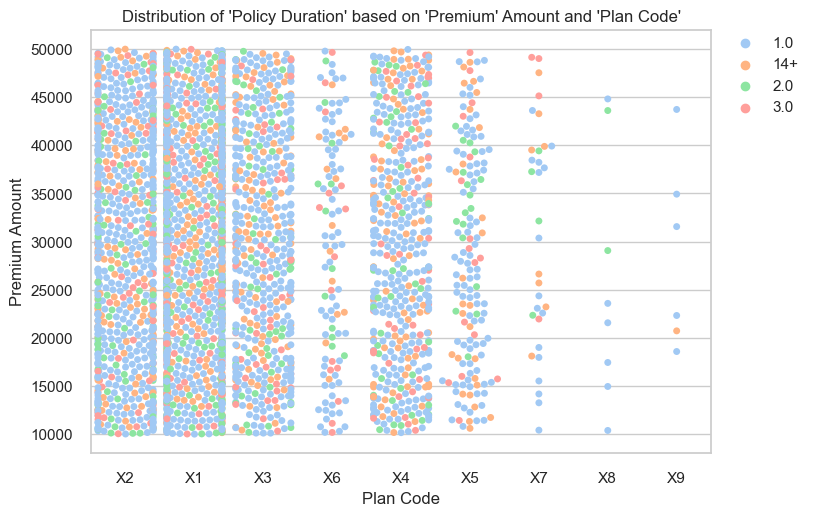

 25%|██▌       | 1/4 [00:05<00:17,  5.80s/it]

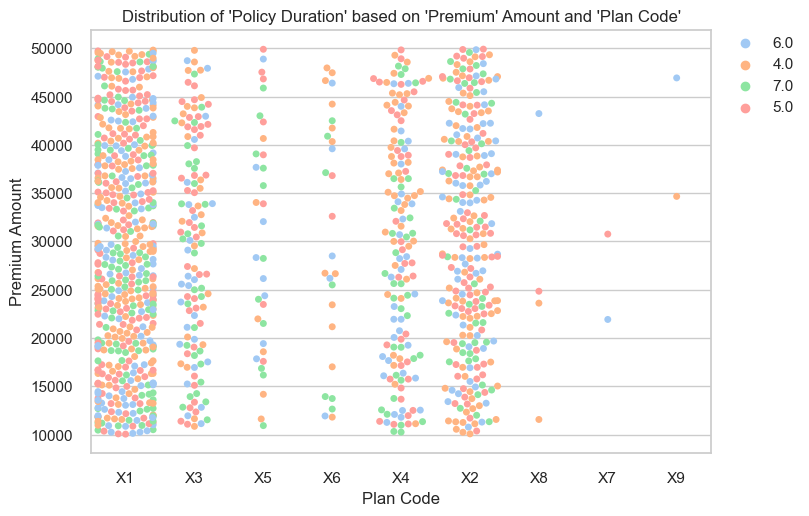

 50%|█████     | 2/4 [00:06<00:06,  3.01s/it]

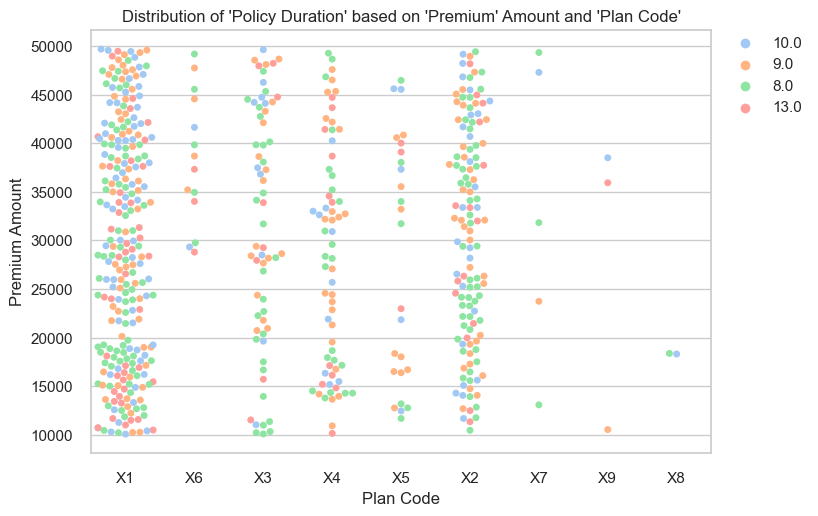

 75%|███████▌  | 3/4 [00:07<00:01,  1.89s/it]

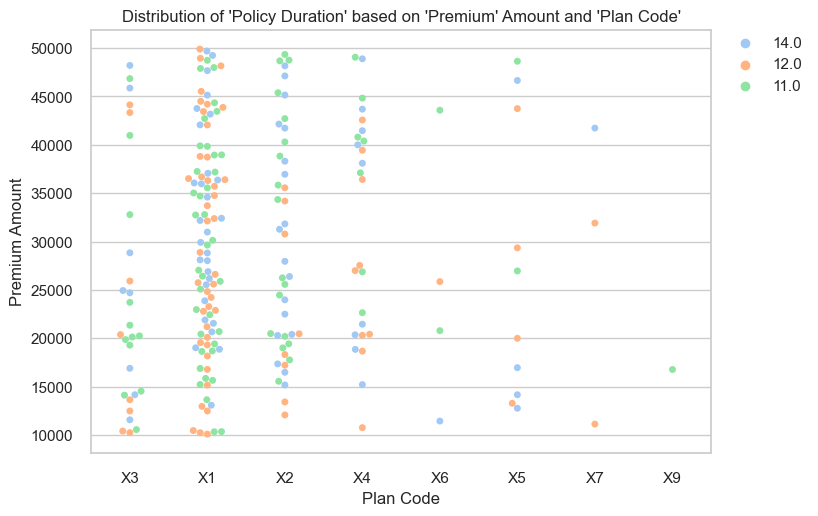

100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


In [22]:
# Creating multiple swarm plots that display 'Plan Code' against 'Premium Amount' and using the 'Policy Duration' column as the hue
polDurList1 = df_forPlanCode['Policy Duration'].value_counts().index.tolist()[:4]
polDurList2 = df_forPlanCode['Policy Duration'].value_counts().index.tolist()[4:8]
polDurList3 = df_forPlanCode['Policy Duration'].value_counts().index.tolist()[8:12]
polDurList4 = df_forPlanCode['Policy Duration'].value_counts().index.tolist()[12:]

df_polDurList1 = df_forPlanCode[df_forPlanCode['Policy Duration'].isin(polDurList1)]
df_polDurList2 = df_forPlanCode[df_forPlanCode['Policy Duration'].isin(polDurList2)]
df_polDurList3 = df_forPlanCode[df_forPlanCode['Policy Duration'].isin(polDurList3)]
df_polDurList4 = df_forPlanCode[df_forPlanCode['Policy Duration'].isin(polDurList4)]

list_dfPolDur = [df_polDurList1, df_polDurList2, df_polDurList3, df_polDurList4]

for i in tqdm(range(len(list_dfPolDur))):
    sns.swarmplot(x=list_dfPolDur[i]['label'], y=list_dfPolDur[i]['Premium Amount'], hue=list_dfPolDur[i]['Policy Duration'])
    plt.title("Distribution of 'Policy Duration' based on 'Premium' Amount and 'Plan Code'")
    plt.ylabel('Premium Amount')
    plt.xlabel('Plan Code')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

By plotting multiple swarm plots that display 'Plan Code' against 'Premium Amount' and using the 'Policy Duration' column as the hue, the underlying trend of the 'Policy Duration' variable distribution can be seen across the 'Plan Code' products

1. The 'Policy Duration' variables 1, 14+, 2, and 3 are prevalent in almost all insurance products, except for X8 and X9 products. These variables are more pronounced in all insurance products, except for X7, X8, and X9 products.
2. The remaining 'Policy Duration' variables are more noticeable in X1, X2, X3, and X4 products.

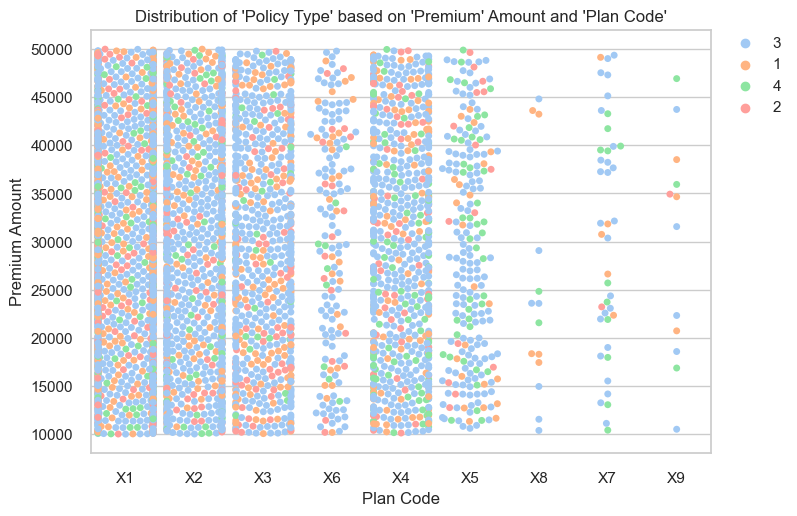

In [23]:
sns.swarmplot(x=df_forPlanCode['label'], y=df_forPlanCode['Premium Amount'], hue=df_forPlanCode['Policy Type'])
plt.title("Distribution of 'Policy Type' based on 'Premium' Amount and 'Plan Code'")
plt.ylabel('Premium Amount')
plt.xlabel('Plan Code')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

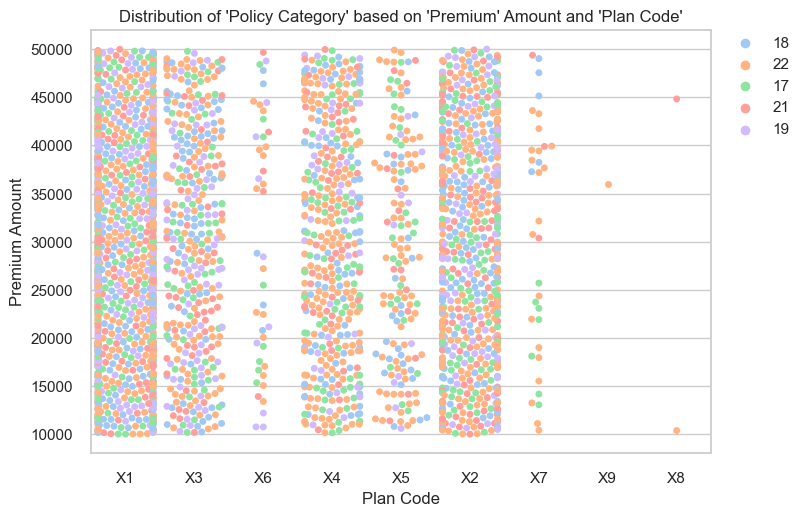

 25%|██▌       | 1/4 [00:04<00:12,  4.23s/it]

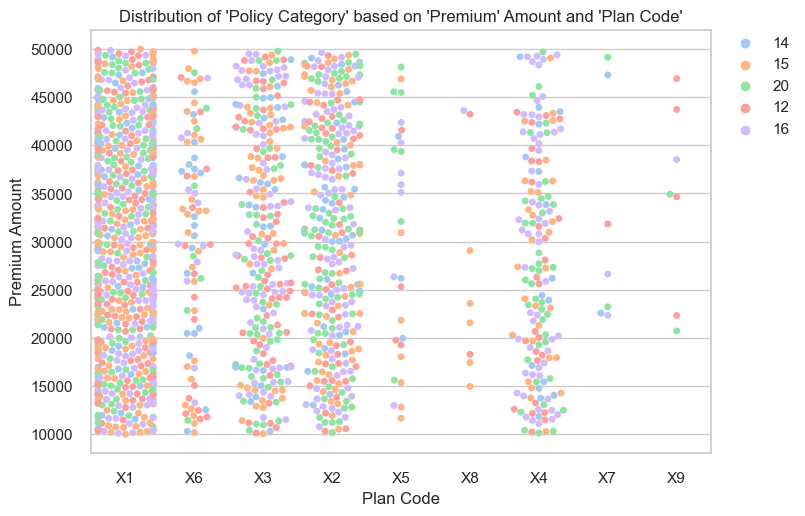

 50%|█████     | 2/4 [00:05<00:05,  2.74s/it]

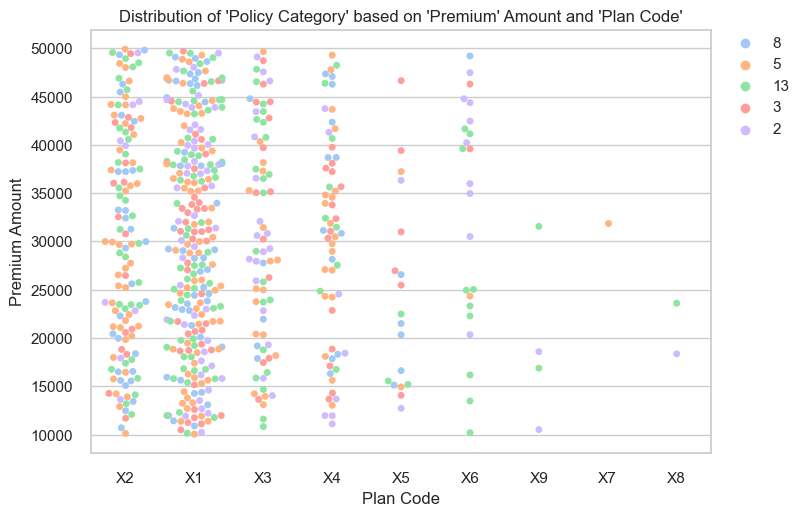

 75%|███████▌  | 3/4 [00:06<00:01,  1.74s/it]

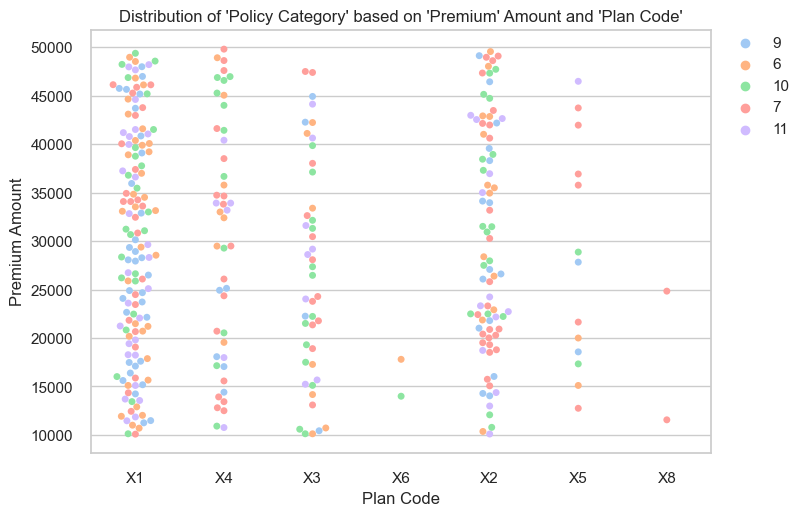

100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


In [24]:
# Creating multiple swarm plots that display 'Plan Code' against 'Premium Amount' and using the 'Policy Category' column as the hue
polCatList1 = df_forPlanCode['Policy Category'].value_counts().index.tolist()[:5]
polCatList2 = df_forPlanCode['Policy Category'].value_counts().index.tolist()[5:10]
polCatList3 = df_forPlanCode['Policy Category'].value_counts().index.tolist()[10:15]
polCatList4 = df_forPlanCode['Policy Category'].value_counts().index.tolist()[15:20]
polCatList5 = df_forPlanCode['Policy Category'].value_counts().index.tolist()[20:]

df_polCatList1 = df_forPlanCode[df_forPlanCode['Policy Category'].isin(polCatList1)]
df_polCatList2 = df_forPlanCode[df_forPlanCode['Policy Category'].isin(polCatList2)]
df_polCatList3 = df_forPlanCode[df_forPlanCode['Policy Category'].isin(polCatList3)]
df_polCatList4 = df_forPlanCode[df_forPlanCode['Policy Category'].isin(polCatList4)]

list_dfPolCat = [df_polCatList1, df_polCatList2, df_polCatList3, df_polCatList4]

for i in tqdm(range(len(list_dfPolCat))):
    sns.swarmplot(x=list_dfPolCat[i]['label'], y=list_dfPolCat[i]['Premium Amount'], hue=list_dfPolCat[i]['Policy Category'])
    plt.title("Distribution of 'Policy Category' based on 'Premium' Amount and 'Plan Code'")
    plt.ylabel('Premium Amount')
    plt.xlabel('Plan Code')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

**Findings:** 
1. The trends for 'Married_Insured,' 'Policy Duration,' 'Policy Type,' and 'Policy Category,' which were previously unclear, have been revealed through these swarm plots. Most of the variables in these features are associated with the X1, X2, X3, and X4 products. 
2. The most dominant variables in 'Plan Code,' 'Policy Duration,' 'Policy Type,' and 'Policy Category' are the X1 product, 1.0 year for policy duration, 3 for policy type, and 22 for policy category, respectively; these variables are found across all segments.

Marketers can utilize these plots as a guide to more effectively target their segments.

In [25]:
# listnum_PremiumAmount
# listcat_PremiumAmount
dfpa = df_forPremiumAmount.copy()
df_labelPlanCode = df_forPremiumAmount.groupby(['label', 'Plan Code']).median()
multi_index = pd.MultiIndex.from_tuples(df_labelPlanCode.index.values, names=['PABinned', 'plan_code'])
df_medianLower = pd.DataFrame(index=multi_index, columns=listnum_PremiumAmount)
df_medianUpper = pd.DataFrame(index=multi_index, columns=listnum_PremiumAmount)

for label in np.sort(dfpa['label'].unique()):
    for pc in np.sort(dfpa['Plan Code'].unique()):
        for column in listnum_PremiumAmount:
            # Grabbing the array of selected label and plan code
            arr_sorted = np.sort(dfpa[(dfpa['label']==label) & (dfpa['Plan Code']==pc)][column].to_numpy())
            
            # Creating lowerbound for multiIndex DF
            median_lowerbound = median_confidenceInterval_lower2(arr_sorted)
            df_medianLower.loc[label].loc[pc, column] = median_lowerbound
            
            # Creating upperbound for multiIndex DF
            median_upperbound = median_confidenceInterval_upper2(arr_sorted)
            df_medianUpper.loc[label].loc[pc, column] = median_upperbound
            
df_medianLower = df_medianLower.astype('float')
df_medianUpper = df_medianUpper.astype('float').fillna(11011011011101)

# Creating median numerical DFs & categorical DF
df_numerGB_MedianCI = df_medianLower.astype('str') + ' - ' + df_medianUpper.astype('str')  # Creating profiling based on the 'median' confidence interval of the data.
df_numerGB_MedianCI = RemoveIntervalDuplicates(df_numerGB_MedianCI)
df_categoGB_Mode = dfpa[listcat_PremiumAmount+['label']].groupby(['label', 'Plan Code']).agg(pd.Series.mode)

# Creating Population & Percent Population DFs
groupPop = dfpa.groupby(['label', 'Plan Code']).count().iloc[:,0].values
df_pop = pd.DataFrame(groupPop, columns=['population'])  # Population per cluster
df_percPop = df_pop.apply(lambda x: round(x/groupPop.sum()*100,2)).copy()  # Percent population per cluster
df_percPop.columns = ['percPopulation']

# Creating mean Premium Amount DF
df_meanPA = pd.DataFrame(dfpa.groupby(['label', 'Plan Code']).mean()['Premium Amount'].apply(lambda x: round(x, 2)).values, columns=['meanPremiumAmount'])

# Combining all DFs into 1
df_result = pd.concat([df_numerGB_MedianCI.reset_index(drop=True), df_categoGB_Mode.reset_index(drop=True), 
                       df_pop.reset_index(drop=True), df_percPop.reset_index(drop=True), 
                       df_meanPA.reset_index(drop=True)], axis=1)

# Creating 'market_size' column
df_result['market_size'] = round(df_result['meanPremiumAmount']*df_result['population'],2)
df_result['market_sizeFormatted'] = df_result['market_size'].apply(lambda x: f"{x:,}")

# Replacing cells that has Nan Values in the upper bound of their median with Nan
for i in listnum_PremiumAmount:
    df_result[i] = df_result[i].str.split(' - ').apply(lambda x: 11011011011101 if float(x[1])==11011011011101 else ' - '.join(x))

# Creating grouped labelPlanCode DF that is based on median
df_labelPlanCode = df_forPremiumAmount.groupby(['label', 'Plan Code']).agg('median')
df_LPCReset = df_labelPlanCode.reset_index(drop=True).copy()

# Replacing the missing values with median
for i in listnum_PremiumAmount:
    for j in df_result.index.values:
        if df_result.loc[j, i]==11011011011101:
            df_result.loc[j, i] = df_LPCReset.loc[j,i]    

df_result.index = multi_index

In [26]:
# Segmenting customer based on 'Plan Code' and 'Premium Amount' that has been quantile-binned
print(f"Below are the bin edges for each quantile: {kbins.bin_edges_.tolist()[0].tolist()}")
# df_result.sort_values('market_size', ascending=False)  # Sorted Version
df_result

Below are the bin edges for each quantile: [10014.0, 17929.2, 25720.8, 33993.8, 41769.0, 49989.0]


Age customer_lifetime     Premium Amount            City Code Married_Insured                  Policy Duration Policy Type   Policy Category  population  percPopulation  meanPremiumAmount  market_size market_sizeFormatted
PABinned plan_code                                                                                                                                                                                                                                       
0.0      X1         49.0 - 54.0         1.0 - 7.0  13566.0 - 14326.0                   C1               2                              1.0           3                22         452            8.16           13899.83   6282723.16         6,282,723.16
         X2         49.0 - 55.0        0.0 - 12.0  13270.0 - 14319.0                   C2               2                              1.0           3                22         244            4.40           13904.46   3392688.24         3,392,688.24
         X3         45.0 - 60.0        0.0 - 13.0  13926.0 - 14919.0                   C1               2                              1.0           3                22         159            2.87           14199.27   2257683.93         2,257,683.93
         X4         45.0 - 55.0        1.0 - 11.0  13500.0 - 14334.0                   C1               2                              1.0           3                22         151            2.73           13862.88   2093294.88         2,093,294.88
         X5         45.0 - 58.0         0.0 - 5.0  13284.0 - 15391.0                   C1               2                              1.0           3                22          55            0.99           14335.09    788429.95           788,429.95
         X6         56.0 - 67.0        0.0 - 17.0  12484.0 - 15361.0             [C1, C2]               2                              1.0           3                15          35            0.63           13746.57    481129.95           481,129.95
         X7                57.5              13.5            13169.5                   C2          [2, 3]                              1.0           3                22           6            0.11           12936.50     77619.00             77,619.0
         X8                50.5              11.5            13261.0    [C1, C2, C28, C7]          [2, 3]                              1.0           3                15           4            0.07           13593.25     54373.00             54,373.0
         X9                38.5               0.0            13700.5             [C2, C3]          [2, 3]                      [11.0, 9.0]      [3, 4]           [13, 2]           2            0.04           13700.50     27401.00             27,401.0
1.0      X1         52.0 - 56.0         1.0 - 8.0  21706.0 - 22439.0                   C1               2                              1.0           3                22         481            8.68           21882.07  10525275.67        10,525,275.67
         X2         47.0 - 53.0         0.0 - 6.0  21231.0 - 22407.0                   C1               2                              1.0           3                22         259            4.68           21786.22   5642630.98         5,642,630.98
         X3         49.0 - 56.0         0.0 - 8.0  21355.0 - 23092.0                   C1               2                              1.0           3                22         140            2.53           22176.67   3104733.80          3,104,733.8
         X4         51.0 - 57.0        0.0 - 11.0  20708.0 - 22831.0                   C1               2                              1.0           3                22         140            2.53           21743.87   3044141.80          3,044,141.8
         X5         46.0 - 66.0        3.0 - 23.0  21174.0 - 23383.0                   C1               2                              1.0           3                22          44            0.79           21766.45    957723.80            957,723.8
         X6         36.0 - 6

**Conclusion:**
1. By using a swarm plot, the underlying distribution of variables that might be difficult to discern in previous customer segmentation tables for various features can be observed more clearly
2. The customer segmentation table above is **based on 'Premium Amount' that has been quantile-binned and the 'Plan Code' columns**. Marketers could utilize this **more refined** customer segmentation and the swarm plots in their marketing strategies.
3. Furthermore, they could also **prioritize the most profitable market segment** by **sorting the 'market_size'** column and then employ the most suitable marketing strategies, including pricing strategies, media campaigns, and media channels, for each of the selected segments.